# SARSCov2 seasonal disentangling with KL annealing

Infection by SARS-Cov-2 results in the respiratory disease COVID-19 and is responsible for the ongoing pandemic. Currently, data science and machine learning approaches to understand and predict the development of the COVID-19 pandemic rely on computer vision or time series analysis. Mainly to identify COVID-19 positive cases from chest X-rays or to predict infection dynamics. However, the use of genetic data for machine learning applications remains scarce. 

Although there are some examples of machine learning modeling of SARS-Cov-2 genome sequences, the genome consists of around 30k bases making it extremely difficult to analyze using modern NLP neural network architectures. The following shows a simple encoding method to analyze large biological sequences and its use for a representation learning task to cluster genomic data. Also how to combine other data sources to understand the meaning of the embedded dimensions. 


## Packages

In [1]:
import re
import os
import numpy as np 
import pandas as pd
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt

from Bio import SeqIO
from io import StringIO
from itertools import product

from numpy import linalg as LA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Dense,Add,concatenate,LeakyReLU
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Layer,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Reshape, BatchNormalization,GlobalMaxPooling2D

globalSeed=768

from numpy.random import seed 
seed(globalSeed)

tf.compat.v1.set_random_seed(globalSeed)

# Working with biological sequences 

In [2]:
#Wrapper function to load the sequences. 
def GetSeqs(Dir):
    
    cDir=Dir
    
    with open(cDir) as file:
        
        seqData=file.read()
        
    Seq=StringIO(seqData)
    SeqList=list(SeqIO.parse(Seq,'fasta'))
    
    return SeqList

def SplitString(String,ChunkSize):
    '''
    Split a string ChunkSize fragments using a sliding windiow

    Parameters
    ----------
    String : string
        String to be splitted.
    ChunkSize : int
        Size of the fragment taken from the string .

    Returns
    -------
    Splitted : list
        Fragments of the string.

    '''
    try:
        localString=str(String.seq)
    except AttributeError:
        localString=str(String)
      
    if ChunkSize==1:
        Splitted=[val for val in localString]
    
    else:
        nCharacters=len(String)
        Splitted=[localString[k:k+ChunkSize] for k in range(nCharacters-ChunkSize)]
        
    return Splitted

def UniqueToDictionary(UniqueElements):
    '''
    Creates a dictionary that takes a Unique element as key and return its 
    position in the UniqueElements array
    Parameters
    ----------
    UniqueElements : List,array
        list of unique elements.

    Returns
    -------
    localDictionary : dictionary
        Maps element to location.

    '''
    
    localDictionary={}
    nElements=len(UniqueElements)
    
    for k in range(nElements):
        localDictionary[UniqueElements[k]]=k
        
    return localDictionary

def CountUniqueElements(UniqueElements,String,Processed=False):
    '''
    Calculates the frequency of the unique elements in a splited or 
    processed string. Returns a list with the frequency of the 
    unique elements. 
    
    Parameters
    ----------
    UniqueElements : array,list
        Elements to be analized.
    String : strting
        Sequence data.
    Processed : bool, optional
        Controls if the sring is already splitted or not. The default is False.
    Returns
    -------
    localCounter : array
        Normalized frequency of each unique fragment.
    '''
    
    nUnique=len(UniqueElements)
    localCounter=[0 for k in range(nUnique)]
    
    if Processed:
        ProcessedString=String
    else:
        ProcessedString=SplitString(String,len(UniqueElements[0]))
        
    nSeq=len(ProcessedString)
    UniqueDictionary=UniqueToDictionary(UniqueElements)
    
    for val in ProcessedString:
        if val in UniqueElements:
            localPosition=UniqueDictionary[val]
            localCounter[localPosition]=localCounter[localPosition]+1      
            
    localCounter=[val/nSeq for val in localCounter]
    
    return localCounter

def MakeSequenceGraph(Sequence,NodeNames,scheme='A',viz=False):
    '''
    Creates a graph from a sequence 
    
    Parameters
    ----------
    Sequence : string, sequence object
        Sequence to create the graph.
    NodeNames : array
        Array with the node names or k-mer for each noe.
    scheme : string, optional default is A
        Controls the connectivity scheme
    viz : bool, optional default is False
        Controls if the graph is multigraph for analysis or 
        a simple graph for visualization
    Returns
    -------
    localGraph : networkx graph object
        Sequence graph.
    '''
    
    Nodes=np.arange(len(NodeNames))
    localDict=UniqueToDictionary(NodeNames)
    
    if viz:
        localGraph=nx.Graph()
    else:    
        localGraph=nx.MultiGraph()
        
    localGraph.add_nodes_from(Nodes)
    
    if scheme == 'A':
        
        fragmentSize=len(NodeNames[0])
        processedSequence=SplitString(Sequence,fragmentSize)
        
        for k in range(len(processedSequence)-1):
            
            if processedSequence[k] in NodeNames and processedSequence[k+1] in NodeNames:
            
                current=localDict[processedSequence[k]]
                forward=localDict[processedSequence[k+1]]
                localGraph.add_edge(current,forward)
    
    elif scheme == 'B':
        
        fragmentSize=2*len(NodeNames[0])
        processedSequence=SplitString(Sequence,fragmentSize)
        
        for frag in processedSequence:
            
            backFragment = frag[0:int(fragmentSize/2)] 
            forwardFragment = frag[int(fragmentSize/2)::]
            
            if backFragment in NodeNames and forwardFragment in NodeNames:
                current = localDict[backFragment]
                forward = localDict[forwardFragment]
                localGraph.add_edge(current,forward)
    
    return localGraph

#Wrapper function to calculate the normalized adjacency matrix 
def MakeNormAdjacencyMatrix(graph):
    
    matrixShape = (len(graph.nodes),len(graph.nodes))
    D12 = np.zeros(matrixShape)
    
    for (node, val) in graph.degree():
        D12[node,node] = 1/np.sqrt(val)
        
    A = nx.adjacency_matrix(graph).toarray()    
    normA = np.dot(D12,A).dot(D12)
    
    w,v = LA.eig(normA)
        
    return normA/LA.norm(w)

Alphabet = ['A','C','T','G']
Blocks = []

maxSize = 4
for k in range(1,maxSize):
    
    Blocks.append([''.join(i) for i in product(Alphabet, repeat = k)])

#Wrapper function to format the matrix data 
def MakeSequenceMatrix(sequence,blocks=Blocks):
    
    container = []
    mat = np.zeros((64,80))
    
    for blk in blocks:
        graphA = MakeSequenceGraph(sequence,blk)
        graphB = MakeSequenceGraph(sequence,blk,scheme='B')
    
        a = MakeNormAdjacencyMatrix(graphA)
        b = MakeNormAdjacencyMatrix(graphB)
    
        c = a-b
        c = (c-c.min())/(c.max()-c.min())
        container.append(c)
    
    mat[0:4,0:4] = container[0]
    mat[4:20,0:16] = container[1]
    mat[0:64,16:80] = container[2]
    
    return mat

def GetGridShape(TotalNumberOfElements):
    """
    Parameters
    ----------
     TotalNumberOfElements : int
        Total number of elements in the plot.

    Returns
    -------
    nrows : int
        number of rows in the plot.
    ncolumns : int
        number of columns in the plot.

    """
    numberOfUnique=TotalNumberOfElements
    squaredUnique=int(np.sqrt(numberOfUnique))
    
    if squaredUnique*squaredUnique==numberOfUnique:
        nrows,ncolumns=squaredUnique,squaredUnique
    elif squaredUnique*(squaredUnique+1)<numberOfUnique:
        nrows,ncolumns=squaredUnique+1,squaredUnique+1
    else:
        nrows,ncolumns=squaredUnique,squaredUnique+1
    
    return nrows,ncolumns

Biological sequences can be categorized into three main groups. DNA sequences, RNA sequences, and protein sequences. Each element in a DNA or RNA sequence represents a nucleoside while the elements of a protein sequence represent an amino acid. From DNA or RNA sequences the corresponding protein sequence can be inferred, but the inverse process is not possible. As the amino acid encoding within the DNA/RNA sequence does not have a one-to-one correspondence. Meaning that single amino acid is encoded in different ways within the DNA/RNA sequence. 

A DNA or RNA sequence consists of 4 different elements, each element represents a nucleoside or nucleobase inside the DNA or RNA chain. Different three elements combinations of nucleobases lead to specific amino acids. While larger combinations usually correspond to regulatory elements inside the sequence. One of the most common methods to encode a text or biological sequence is to use a binary representation of the sequence or one-hot encoding. However, this type of encoding increases the dimensionality of the data for large sequences. 

A simple solution to the dimensionality and problem will be to encode the relationship between different elements in the sequence rather than the elements. In a relational encoding scheme, a link is added between two elements if the two elements are consecutive. This simple definition leaves room to process the sequence in different ways creating different encodings of the same sequence. 

In the case of the SARS Cov 2 sequences, two connectivity schemes are proposed. In the first one, each sequence is divided into k size fragments and a link is added to consecutive fragments in the sequence. While in the second one each sequence is divided into 2k size fragments, then the fragment is divided into two k size fragments and a link is added between the two consecutive fragments. Each connectivity scheme can be visualized as graphs showing specific patterns. 


In [3]:
Sequences = GetSeqs('../input/covid19-sequences/sequences.fasta')

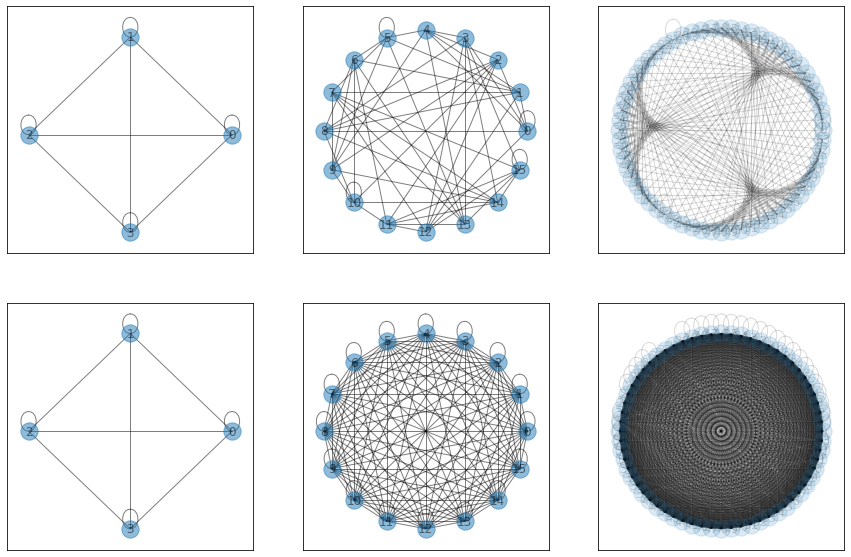

In [4]:
Mer01Graph = MakeSequenceGraph(Sequences[0],Blocks[0],viz=True)
pos01 = nx.circular_layout(Mer01Graph)

Mer02Graph = MakeSequenceGraph(Sequences[0],Blocks[1],viz=True)
pos02 = nx.circular_layout(Mer02Graph)

Mer03Graph = MakeSequenceGraph(Sequences[0],Blocks[2],viz=True)
pos03 = nx.circular_layout(Mer03Graph)

Mer01GraphB = MakeSequenceGraph(Sequences[0],Blocks[0],scheme='B',viz=True)
pos01B = nx.circular_layout(Mer01Graph)

Mer02GraphB = MakeSequenceGraph(Sequences[0],Blocks[1],scheme='B',viz=True)
pos02B = nx.circular_layout(Mer02Graph)

Mer03GraphB = MakeSequenceGraph(Sequences[0],Blocks[2],scheme='B',viz=True)
pos03B = nx.circular_layout(Mer03Graph)

f, axs = plt.subplots(2,3,figsize=(15,10))

nx.draw_networkx(Mer01Graph, pos=pos01, ax=axs[0,0],alpha=0.5)
nx.draw_networkx(Mer02Graph, pos=pos02, ax=axs[0,1],alpha=0.5)
nx.draw_networkx(Mer03Graph, pos=pos03, ax=axs[0,2],alpha=0.15)

nx.draw_networkx(Mer01GraphB, pos=pos01B, ax=axs[1,0],alpha=0.5)
nx.draw_networkx(Mer02GraphB, pos=pos02B, ax=axs[1,1],alpha=0.5)
nx.draw_networkx(Mer03GraphB, pos=pos03B, ax=axs[1,2],alpha=0.15)

As each k relational encoding is defined as a graph, the adjacency matrix will contain the frequency of each connection. This matrix ix normalized with $D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$. Where D is the degree matrix and A the adjacency matrix, then this matrix is scaled by dividing it by its Frobenius norm. Then the difference between scheme A and scheme B is used as the final representation for a k size sequence fragment. Arranging the different normalized matrices up to the 3 size fragment results in the following 2D array. 

This array can be used as a single channel image and use one of the many neural network architectures optimized for computer vision. Another advantage for this kind of encoding is that longe range dependencies in the sequence might be closer in the 2D sequence representation.  

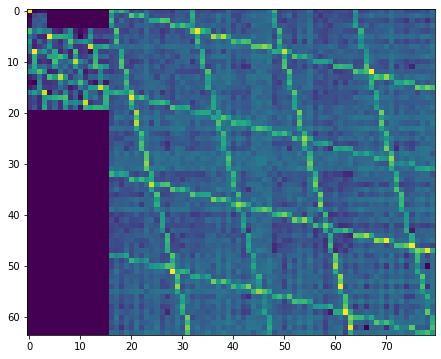

In [5]:
plt.figure(figsize=(12,6))
plt.imshow(MakeSequenceMatrix(Sequences[0]))

# Dataset generation and subsampling. 

With a simple sequence representation in place, a subsample of the graph sequence data set is taken as training data. Particularly the sequences isolated in the northeast coast of the USA. Sequence ids approximately match the file names in the Covid-19 Graph Sequences data set. The main difference is that the file names contain the sequence version as stated in the FASTA record of the sequence. While the metadata contains only the sequence id without version. 

Text(0.5, 0, 'Time')

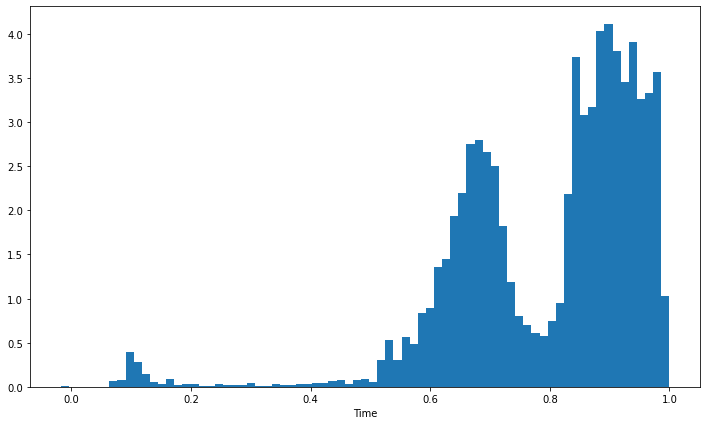

In [6]:
MetaData = pd.read_csv(r'../input/covid19-metadata/SARSCov2Metadata.csv')
MetaData.drop(['PCA_A','PCA_B','VAE_A','VAE_B','ConvVAE_A','ConvVAE_B',],axis=1,inplace=True)
MetaData.fillna(0,inplace=True)
USData = MetaData[MetaData['SimplifiedGEO']=="USA"]

EastCoastDataA = USData[USData["geo_long"]>-85]
NorthEastCoast = EastCoastDataA[EastCoastDataA["geo_lat"]>35]

plt.figure(figsize=(12,7))
plt.hist(NorthEastCoast['outbreaktime'],bins=75,density=True)
plt.xlabel('Time')

# Network definition 

Network construction can be divided into three main parts, the convolutional block, the dense bottleneck, and the variational layers. And those components are combined with three wrapper functions. Two merge the networks to create the variational autoencoder, MakeAutoencoder creates an autoencoder without the variational layers, while MakeVariationalAutoencoder defines the variational autoencoder. While CoderByBlock creates the main body of the convolutional autoencoder, it takes a function that creates a simple convolutional network and the number of filters to apply for each convolutional block. This allows changing the main architecture of the network by modifying only one function for fast experimentation. 

The main convolutional block consists of a dense convolutional network with a LeakyReLU activation function. Downsampling is done by setting strides to (2,2) on the final Conv2D layer within the block and UpSampling by changing the Conv2D layer to Conv2DTranspose with the same strides configuration. The output of this is then connected to a channel and spatial attention module. 

To dynamically weight the KL loss of the autoencoder a TensorFlow variable is added to the KL layer and trainable is set to false. This incorporates the new variable into the network weights. Then the new variable is changed with a callback at the end of each epoch. 

Finally, the data is loaded using the sequence class to load and reshape the data. 

### Custom layers

In [7]:
class KLDivergenceLayer(Layer):
    '''
    Custom KL loss layer
    '''
    def __init__(self,*args,**kwargs):
        self.annealing = tf.Variable(0.,dtype=tf.float32,trainable = False)
        self.is_placeholder=True
        super(KLDivergenceLayer,self).__init__(*args,**kwargs)
        
    def call(self,inputs):
        
        Mu,LogSigma=inputs
        klbatch=-0.5*self.annealing*K.sum(1+LogSigma-K.square(Mu)-K.exp(LogSigma),axis=-1)
        self.add_loss(K.mean(klbatch),inputs=inputs)
        self.add_metric(klbatch,name='kl_loss',aggregation='mean')
        
        return inputs

class Sampling(Layer):
    '''
    Custom sampling layer
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def get_config(self):
        config = {}
        base_config = super().get_config()
        return {**base_config, **config}
    
    @tf.autograph.experimental.do_not_convert   
    def call(self,inputs,**kwargs):
        
        Mu,LogSigma=inputs
        batch=tf.shape(Mu)[0]
        dim=tf.shape(Mu)[1]
        epsilon=K.random_normal(shape=(batch,dim))

        return Mu+(K.exp(0.5*LogSigma))*epsilon

class SpatialAttention(Layer):
    '''
    Custom Spatial attention layer
    '''
    
    def __init__(self,size, **kwargs):
        super(SpatialAttention, self).__init__()
        self.size = size
        self.kwargs = kwargs

    def build(self, input_shapes):
        self.conv = Conv2D(filters=1, kernel_size=self.size, strides=1, padding='same')

    def call(self, inputs):
        pooled_channels = tf.concat(
            [tf.math.reduce_max(inputs, axis=3, keepdims=True),
            tf.math.reduce_mean(inputs, axis=3, keepdims=True)],
            axis=3)

        scale = self.conv(pooled_channels)
        scale = tf.math.sigmoid(scale)

        return inputs * scale

class ChannelAttention(Layer):
    
    def __init__(self,**kwargs):
        super(ChannelAttention,self).__init__()
        self.kwargs = kwargs
    
    def get_config(self):
        config = super(ChannelAttention,self).get_config().copy()
        config.update({'ratio':self.ratio})
        return config
    
    def build(self,input_shape):
        channel = input_shape[-1]
        self.dense0 = Dense(channel)
        self.dense1 = Dense(channel)
    
    def call(self,inputs):
        
        channel = inputs.get_shape().as_list()[-1]
        
        avgpool = GlobalAveragePooling2D()(inputs)
        avgpool = Reshape((1,1,channel))(avgpool)
        avgpool = self.dense0(avgpool)
        avgpool = self.dense1(avgpool)
        
        maxpool = GlobalMaxPooling2D()(inputs)
        maxpool = Reshape((1,1,channel))(maxpool)
        maxpool = self.dense0(maxpool)
        maxpool = self.dense1(maxpool)
        
        feature = Add()([avgpool,maxpool])
        feature = Activation('sigmoid')(feature)
        
        return inputs*feature

### Network definition

In [8]:
#Wrapper function, creates a small Functional keras model 
#Bottleneck of the variational autoencoder 
def MakeVariationalNetwork(Latent):
    
    InputFunction=Input(shape=(Latent,))
    Mu=Dense(Latent)(InputFunction)
    LogSigma=Dense(Latent)(InputFunction)
    Mu,LogSigma=KLDivergenceLayer(name='KLDivergence')([Mu,LogSigma])
    Output=Sampling()([Mu,LogSigma])
    variationalBottleneck=Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,variationalBottleneck

def MakeBottleneck(InputShape,Latent,UpSampling=False):
    '''
    Parameters
    ----------
    InputShape : tuple
        input shape of the previous convolutional layer.
    Latent : int
        Dimentionality of the latent space.
    UpSampling : bool, optional
        Controls the sampling behaviour of the network.
        The default is False.

    Returns
    -------
    InputFunction : Keras functional model input
        input of the network.
    localCoder : Keras functional model
        Coder model, transition layer of the bottleneck.

    '''
    
    productUnits = np.product(InputShape)
    Units = [productUnits,productUnits//4,productUnits//16,Latent]
    
    if UpSampling:
        finalUnits = Units[::-1]
        InputFunction = Input(shape=(Latent,))
        X = Dense(finalUnits[0],use_bias=False)(InputFunction)
    
    else:
        finalUnits = Units
        InputFunction = Input(shape=InputShape)
        X = Flatten()(InputFunction)
        X = Dense(finalUnits[0],use_bias=False)(X)
                
    
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    for k in range(1,len(Units)-1):
        
        X = Dense(finalUnits[k],use_bias=False)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU()(X)
    
    X = Dense(finalUnits[-1],use_bias=False)(X)
    
    if UpSampling:
        X=LeakyReLU()(X)
        Output=Reshape(InputShape)(X)
    else:
        Output=LeakyReLU()(X)
        
    Bottleneck=Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,Bottleneck

def MakeConvolutionBlock(X, Convolutions):
    
    X = Conv2D(Convolutions, (3, 3), padding='same',use_bias=False)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)

    return X

def MakeDenseBlock(x, Convolutions,Depth):

    concat_feat= x
    for i in range(Depth):
        x = MakeConvolutionBlock(concat_feat,Convolutions)
        concat_feat=concatenate([concat_feat,x])

    return concat_feat

def SamplingBlock(X,Units,Depth,UpSampling=False):
    
    X = MakeDenseBlock(X,Units,Depth)
    
    if UpSampling:
        X = Conv2DTranspose(Units,(3,3),strides=(2,2),padding='same',use_bias=False)(X)
    else:    
        X = Conv2D(Units,(3,3),strides=(2,2),padding='same',use_bias=False)(X)
    
    X = ChannelAttention()(X)
    X = SpatialAttention(3)(X)
    
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    return X 
    
def CoderByBlock(InputShape,Units,Depth,UpSampling=False):
    
    if UpSampling:
        Units=Units[::-1]
    else:
        Units=Units
    
    InputFunction = Input(shape=InputShape)
    X = SamplingBlock(InputFunction,Units[0],Depth,UpSampling=UpSampling)
    
    for k in range(1,len(Units)-1):
        
        if Depth-k+1 <= 1:
            blockSize = 2
        else:
            blockSize = Depth-k
        
        X = SamplingBlock(X,Units[k],blockSize,UpSampling=UpSampling)
        
    if UpSampling:
        X = Conv2D(1,(3,3),padding='same',use_bias=False)(X)
        Output = Activation('sigmoid')(X)
    else:
        X = Conv2D(Units[-1],(3,3),padding='same',use_bias=False)(X)
        Output = LeakyReLU()(X)
        
    coderModel = Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,coderModel

#Wrapper function joins the Coder function and the bottleneck function 
#to create a simple autoencoder
def MakeAutoencoder(CoderFunction,InputShape,Units,BlockSize,**kwargs):
    
    InputEncoder,Encoder=CoderFunction(InputShape,Units,BlockSize,**kwargs)
    EncoderOutputShape=Encoder.layers[-1].output_shape
    BottleneckInputShape=EncoderOutputShape[1::]
    InputBottleneck,Bottleneck=MakeBottleneck(BottleneckInputShape,2)
    ConvEncoderOutput=Bottleneck(Encoder(InputEncoder))
    
    ConvEncoder=Model(inputs=InputEncoder,outputs=ConvEncoderOutput)
    
    rInputBottleneck,rBottleneck=MakeBottleneck(BottleneckInputShape,2,UpSampling=True)
    InputDecoder,Decoder=CoderFunction(BottleneckInputShape,Units,BlockSize,UpSampling=True,**kwargs)
    ConvDecoderOutput=Decoder(rBottleneck(rInputBottleneck))
    ConvDecoder=Model(inputs=rInputBottleneck,outputs=ConvDecoderOutput)
    
    ConvAEoutput=ConvDecoder(ConvEncoder(InputEncoder))
    ConvAE=Model(inputs=InputEncoder,outputs=ConvAEoutput)
    
    return InputEncoder,InputDecoder,ConvEncoder,ConvDecoder,ConvAE

# Wrapper functon, joins the autoencoder function with the custom variational
#layers to create an autoencoder
def MakeVariationalAutoencoder(CoderFunction,InputShape,Units,BlockSize,**kwargs):
    
    InputEncoder,InputDecoder,ConvEncoder,ConvDecoder,_=MakeAutoencoder(CoderFunction,InputShape,Units,BlockSize,**kwargs)
    
    InputVAE,VAE=MakeVariationalNetwork(2)
    VAEencoderOutput=VAE(ConvEncoder(InputEncoder))
    ConvVAEencoder=Model(inputs=InputEncoder,outputs=VAEencoderOutput)
    
    VAEOutput=ConvDecoder(ConvVAEencoder(InputEncoder))
    ConvVAEAE=Model(inputs=InputEncoder,outputs=VAEOutput)
    
    return InputEncoder,InputDecoder,ConvVAEencoder,ConvDecoder,ConvVAEAE    

### Auxiliary functions

In [9]:
class DataSequence(Sequence):
    
    def __init__(self, x_set,batch_size):
        self.x = x_set
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    def __data_generation(self, dirList):
         
        X = np.array([np.load(val) for val in dirList])
        X = X.reshape((-1,64,80,1))
        y = X

        return X,y

    def __getitem__(self,idx):
        batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = self.__data_generation(batch_x)
        
        return X,y

class KLAnnealing(keras.callbacks.Callback):

    def __init__(self,position, weigths):
        super().__init__()
        self.position = position
        self.weigths = tf.Variable(weigths,trainable=False,dtype=tf.float32)

    def on_epoch_end(self, epoch,logs=None):
        
        weights = self.model.get_weights()
        weights[self.position] = self.weigths[epoch]
        self.model.set_weights(weights)


def MakeAnnealingWeights(epochs,cycles,scale=1):
    
    pointspercycle = epochs//cycles
    AnnealingWeights = 1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle))))
    
    for k in range(cycles-1):
        AnnealingWeights = np.append(AnnealingWeights,1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle+1)))))
        
    return scale*AnnealingWeights

# Training

In [10]:
GlobalDirectory=r"../input/covid19-graph-sequences"
matrixData = GlobalDirectory + '/featuresdata'

fileNames = os.listdir(matrixData)
northNames = [val+'.1.npy' for val in NorthEastCoast['id']]
finalNamesNorth = list(set(northNames).intersection(fileNames))
pathsNorth = np.array([matrixData+'/'+val for val in finalNamesNorth]) 

input_shape = (64,80,1)
Arch = [12,24,36,48,36]
Depth = 4

lr = 0.0001
minlr = 0.000001
epochs = 60
batch_size = 128
decay = 2*(lr-minlr)/epochs

AnnealingWeights = MakeAnnealingWeights(epochs,4,scale=0.00001)

_,_,Encoder,Decoder,AE = MakeVariationalAutoencoder(CoderByBlock,input_shape,Arch,Depth)
AE.summary()
KLAposition = [k for k,val in enumerate(AE.get_weights()) if len(val.shape)==0][0]

trainPaths,testPaths,_,_ = train_test_split(pathsNorth,pathsNorth,test_size=0.1, random_state=42)

FullLoad = DataSequence(pathsNorth,batch_size)
TrainLoad = DataSequence(trainPaths,batch_size)
TestLoad = DataSequence(testPaths,batch_size)


2022-01-14 01:11:37.758379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 01:11:37.848728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 01:11:37.849407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 01:11:37.850494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 80, 1)]       0         
_________________________________________________________________
model_8 (Functional)         (None, 2)                 851063    
_________________________________________________________________
model_5 (Functional)         (None, 64, 80, 1)         616306    
Total params: 1,467,369
Trainable params: 1,463,248
Non-trainable params: 4,121
_________________________________________________________________


In [11]:
AE.compile(Adam(learning_rate=lr,decay=decay),loss='mse')
history =  AE.fit(TrainLoad,epochs=epochs,
                  validation_data=TestLoad,workers=8,
                  callbacks=[KLAnnealing(KLAposition,AnnealingWeights)])
    
VariationalRepresentationNorth = Encoder.predict(FullLoad)

2022-01-14 01:11:45.584779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-01-14 01:11:55.137598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1112/1112 [==============================] - 206s 172ms/step - loss: 0.0032 - kl_loss: 0.0000e+00 - val_loss: 2.1222e-04 - val_kl_loss: 0.0000e+00
Epoch 2/60
1112/1112 [==============================] - 174s 156ms/step - loss: 1.8832e-04 - kl_loss: 6.9398e-09 - val_loss: 1.6489e-04 - val_kl_loss: 6.2012e-09
Epoch 3/60
1112/1112 [==============================] - 173s 155ms/step - loss: 1.3000e-04 - kl_loss: 3.2230e-08 - val_loss: 1.0246e-04 - val_kl_loss: 3.6113e-08
Epoch 4/60
1112/1112 [==============================] - 173s 156ms/step - loss: 9.3610e-05 - kl_loss: 1.7455e-07 - val_loss: 8.4141e-05 - val_kl_loss: 1.7850e-07
Epoch 5/60
1112/1112 [==============================] - 174s 155ms/step - loss: 6.8559e-05 - kl_loss: 9.1444e-07 - val_loss: 5.8796e-05 - val_kl_loss: 8.5255e-07
Epoch 6/60
1112/1112 [==============================] - 174s 156ms/step - loss: 5.0010e-05 - kl_loss: 4.1130e-06 - val_loss: 4.2562e-05 - val_kl_loss: 4.4203e-06
Epoch 7/60
1112/1112 [=====================

# Adding the metadata 

In [12]:
NorthDataSet = NorthEastCoast.set_index('id')
NorthIds = [val[0:-6] for val in finalNamesNorth]
NorthDataSet = NorthDataSet.loc[NorthIds]
NorthDataSet["latentA"] = VariationalRepresentationNorth[:,0]
NorthDataSet["latentB"] = VariationalRepresentationNorth[:,1]

To understand the encoded meaning of the learned representations we can add new metadata and encode that information. One simple visual technique will be to color code the isolation date of the different SARS Cov 2 sequences. This will visually show any kind of pattern in the data. 

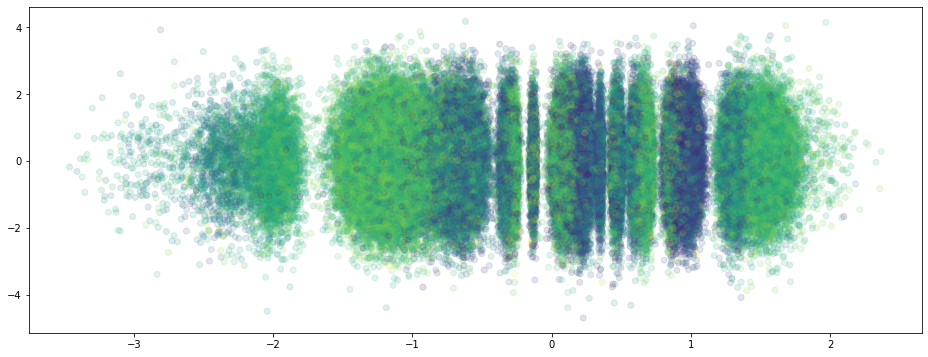

In [13]:
plt.figure(figsize=(16,6))
plt.scatter(NorthDataSet["latentA"],NorthDataSet["latentB"],c=NorthDataSet['week'],alpha=0.15)

Another technique will be to analyze the different clusters in the representation. Clustering by itself might not provide a definitive answer, but it could help us to analyze each cluster individually. 

In [14]:
ConvVAEkmeans =  DBSCAN(eps=0.025,min_samples=10,algorithm='ball_tree',metric='euclidean',n_jobs=-2).fit(NorthDataSet[['latentA','latentB']])
clustersLabels,counts = np.unique(ConvVAEkmeans.labels_,return_counts=True)
clabels = []

for val,sal in zip(clustersLabels,counts):
    if sal>1000 and val!=-1:
        clabels.append(val)#removes outliers and low populated clusters

localColors = [plt.cm.seismic(val) for val in np.linspace(0,1,num=len(clabels))]
NorthDataSet['CLabels'] = [val if val in clabels else -1 for val in ConvVAEkmeans.labels_]

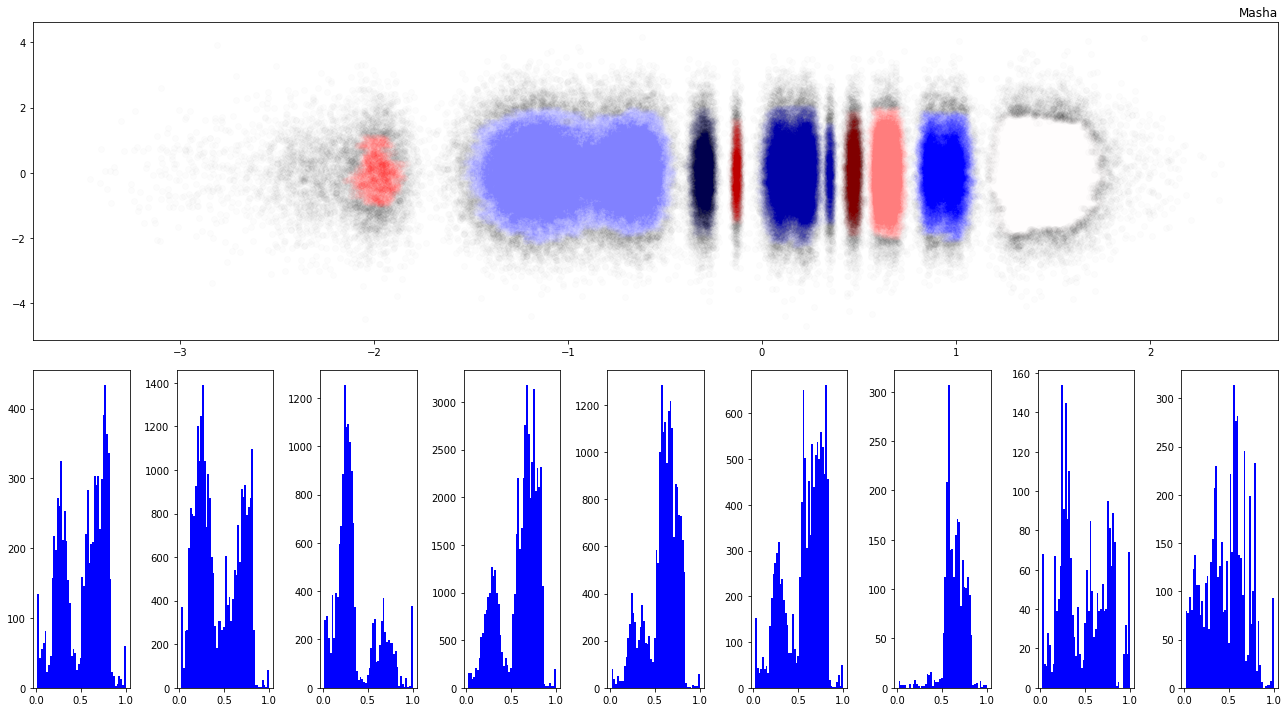

In [15]:
plt.figure(figsize=(18,10))

gs = plt.GridSpec(2,len(clabels))
ax0 = plt.subplot(gs[0,:])

for k,col in zip(clabels,localColors):
    ax0.scatter(NorthDataSet[NorthDataSet['CLabels']==k]['latentA'],NorthDataSet[NorthDataSet['CLabels']==k]['latentB'],c=col,alpha=0.0125)

ax0.scatter(NorthDataSet[NorthDataSet['CLabels']==-1]['latentA'],NorthDataSet[NorthDataSet['CLabels']==-1]['latentB'],c='black',alpha=0.0125)
ax0.set_title('Masha',loc='right')

k=0
for clust,colr in zip(clabels,localColors):
    
    axes = plt.subplot(gs[1,k])
    axes.hist(NorthDataSet[NorthDataSet['CLabels']==clust]['week'],bins=50,color='blue')
    k=k+1
    
plt.tight_layout()

One simple analysis of the cluster information will be to measure the quantity of each of the different nucleobases in the sequence and how they change from cluster to cluster. And how that content changes through time within each cluster, dividing the cluster into two periods, the first half of the year and the second half of the year. 

In [16]:
KmersData = pd.read_csv('../input/covid19-sequence-kmer-frequencies/KmerData.csv')
KmersData['id'] = [val[0:-2] for val in KmersData['id']]
KmersData = KmersData.set_index('id')

nrows,ncolumns = GetGridShape(len(clabels))
subPlotIndexs=[(j,k) for j in range(nrows) for k in range(ncolumns)]

## Adenine Shift

Text(0.9, 0.9, 'Adenine shift')

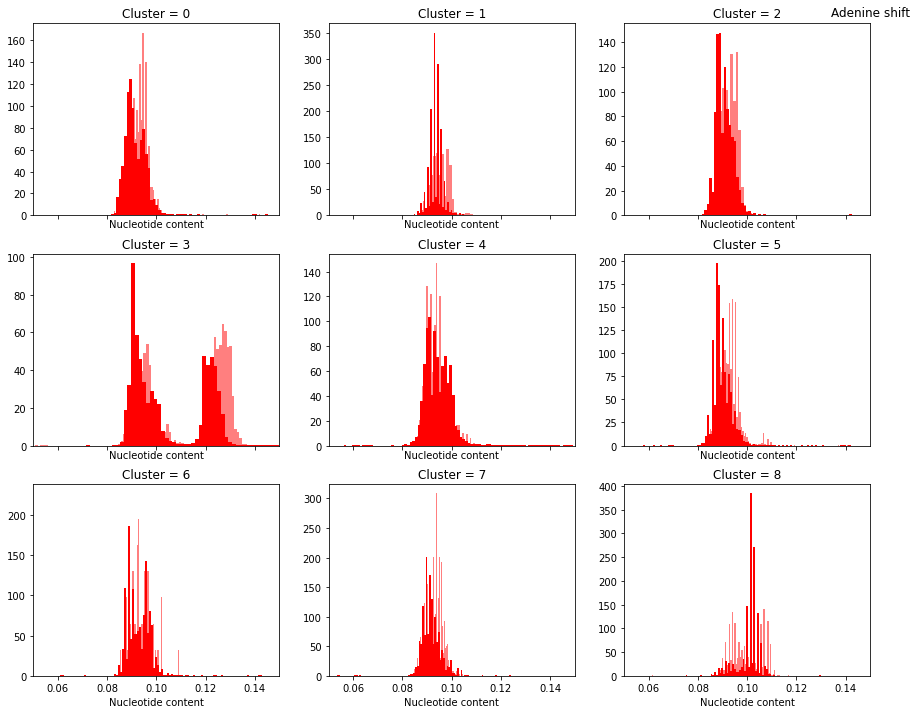

In [17]:
fig,axes=plt.subplots(nrows,ncolumns,figsize=(15,12),sharex=True)
for k,kal in enumerate(clabels):
    
    clusterData = NorthDataSet[NorthDataSet['CLabels']==kal]
    low = clusterData[clusterData['week']<0.5].index
    high = clusterData[clusterData['week']>0.5].index
    axes[subPlotIndexs[k]].hist(KmersData['A'].loc[high],color='red',bins=100,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].hist(KmersData['A'].loc[low],color='red',bins=100,alpha=0.5,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].set_xlim([0.05,0.15])
    axes[subPlotIndexs[k]].set_xlabel('Nucleotide content')
    axes[subPlotIndexs[k]].set_title('Cluster = ' + str(kal))
fig.suptitle('Adenine shift',x=0.9,y=0.9)

## Cytosine shift

Text(0.9, 0.9, 'Cytosine shift')

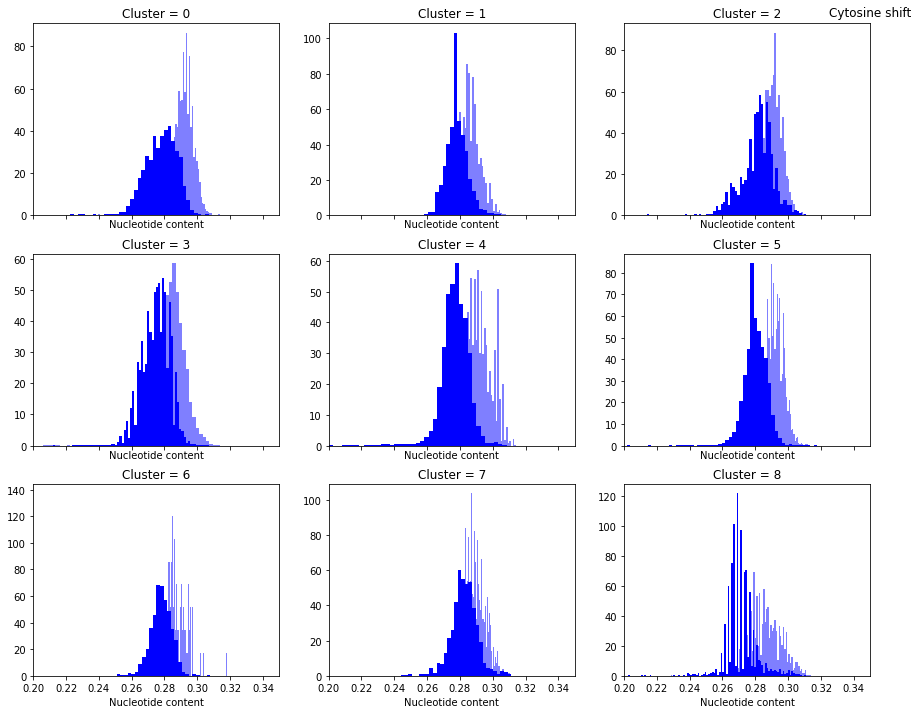

In [18]:
fig,axes=plt.subplots(nrows,ncolumns,figsize=(15,12),sharex=True)
for k,kal in enumerate(clabels):
    
    clusterData = NorthDataSet[NorthDataSet['CLabels']==kal]
    low = clusterData[clusterData['week']<0.5].index
    high = clusterData[clusterData['week']>0.5].index
    axes[subPlotIndexs[k]].hist(KmersData['C'].loc[high],color='blue',bins=100,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].hist(KmersData['C'].loc[low],color='blue',bins=100,alpha=0.5,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].set_xlim([0.2,0.35])
    axes[subPlotIndexs[k]].set_xlabel('Nucleotide content')
    axes[subPlotIndexs[k]].set_title('Cluster = ' + str(kal))
    
fig.suptitle('Cytosine shift',x=0.9,y=0.9)

## Guanine shift

Text(0.9, 0.9, 'Guanine shift')

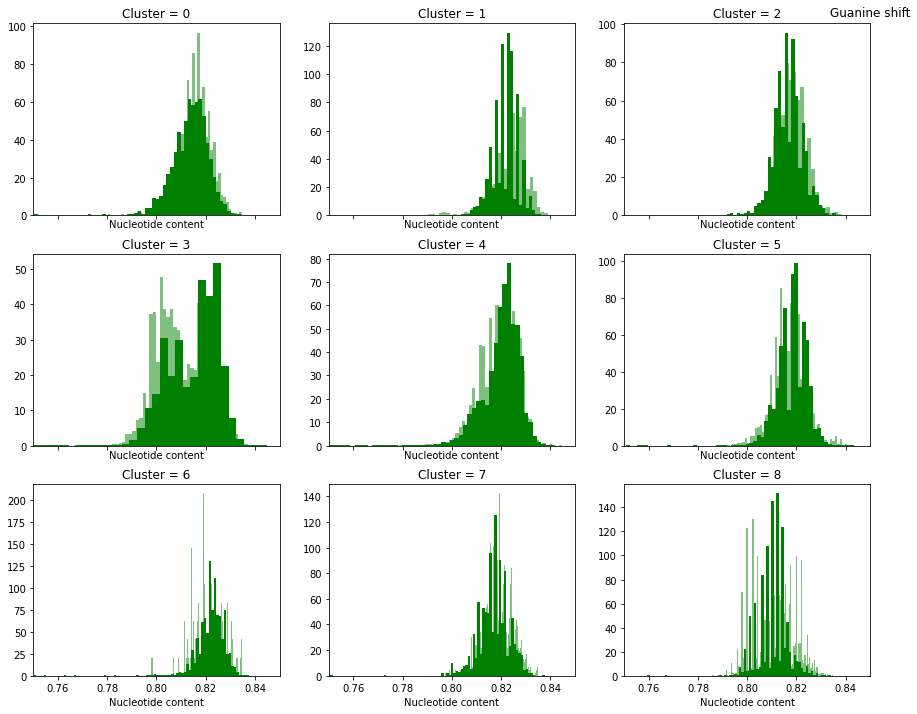

In [19]:
fig,axes=plt.subplots(nrows,ncolumns,figsize=(15,12),sharex=True)
for k,kal in enumerate(clabels):
    
    clusterData = NorthDataSet[NorthDataSet['CLabels']==kal]
    low = clusterData[clusterData['week']<0.5].index
    high = clusterData[clusterData['week']>0.5].index
    axes[subPlotIndexs[k]].hist(KmersData['G'].loc[high],color='green',bins=100,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].hist(KmersData['G'].loc[low],color='green',bins=100,alpha=0.5,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].set_xlim([0.75,0.85])
    axes[subPlotIndexs[k]].set_xlabel('Nucleotide content')
    axes[subPlotIndexs[k]].set_title('Cluster = ' + str(kal))
fig.suptitle('Guanine shift',x=0.9,y=0.9)

## Thymine/Uracil shift

Text(0.9, 0.9, 'Thymine/Uracil shift')

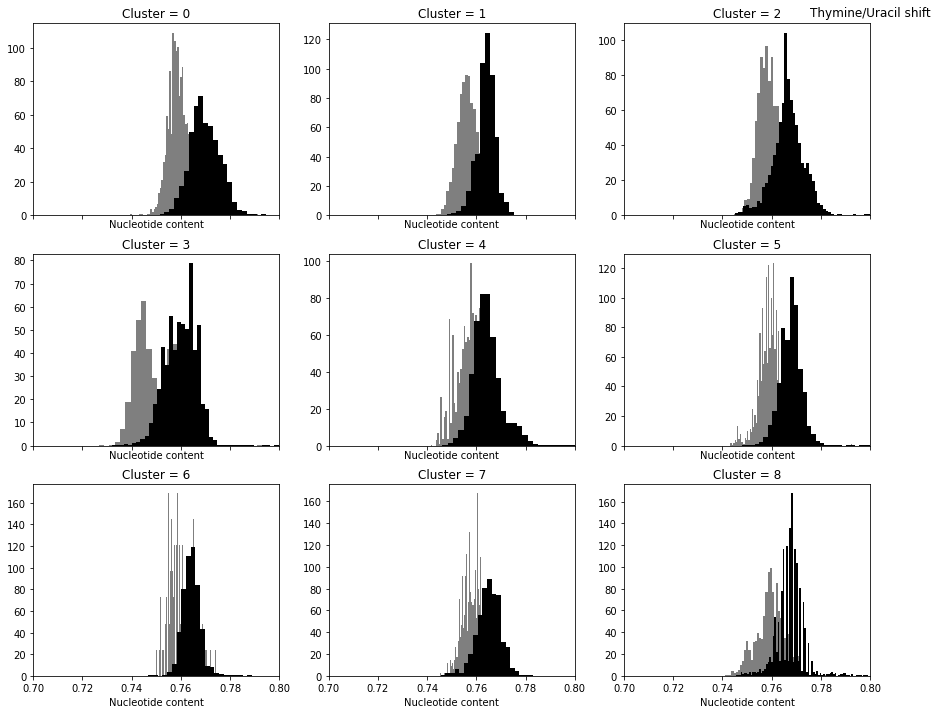

In [20]:
fig,axes=plt.subplots(nrows,ncolumns,figsize=(15,12),sharex=True)
for k,kal in enumerate(clabels):
    
    clusterData = NorthDataSet[NorthDataSet['CLabels']==kal]
    low = clusterData[clusterData['week']<0.5].index
    high = clusterData[clusterData['week']>0.5].index
    axes[subPlotIndexs[k]].hist(KmersData['T'].loc[high],color='black',bins=100,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].hist(KmersData['T'].loc[low],color='black',bins=100,alpha=0.5,density=True,label='Cluster = '+str(kal))
    axes[subPlotIndexs[k]].set_xlim([0.7,0.8])
    axes[subPlotIndexs[k]].set_xlabel('Nucleotide content')
    axes[subPlotIndexs[k]].set_title('Cluster = ' + str(kal))
fig.suptitle('Thymine/Uracil shift',x=0.9,y=0.9)

From the nucleobase content analysis, a clear shift in the content of Cytosine and Thymine/Uracil is found on every cluster. This particular characteristic might be useful for other interventions. 

# Adding infection dynamics

Another kind of metadata to add to the learned representations is the dynamics of the cases in the particular region. Three states will be taken as examples and the total cases per week are plotted against the mean value of each data point in that week from that state. To add the dynamics of the process, the cases rate and acceleration are also compared. This hopefully results in additional information encoded in the learned representation. 

In [21]:
USAInfectionData = pd.read_csv('../input/us-covid19-dataset-live-hourlydaily-updates/States.csv')
USAInfectionData["datets"] = pd.to_datetime(USAInfectionData['date'],format='%Y-%m-%d')
USAInfectionData["year"] = USAInfectionData["datets"].dt.year
USAInfectionData["week"] = USAInfectionData["datets"].dt.isocalendar().week
USAInfection2021 = USAInfectionData[USAInfectionData["year"]==2021]

GetDataByState = lambda state : np.array(USAInfection2021[USAInfection2021["state"]==state].groupby("week")["cases"].sum())[0:-2]

States = ["Maine","Vermont","New Hampshire","Massachusetts","Rhode Island","New York","Connecticut",
         "New Jersey","Pennsylvania","Delaware"]

StateData = np.array([GetDataByState(st)/GetDataByState(st).max() for st in States])

## New York

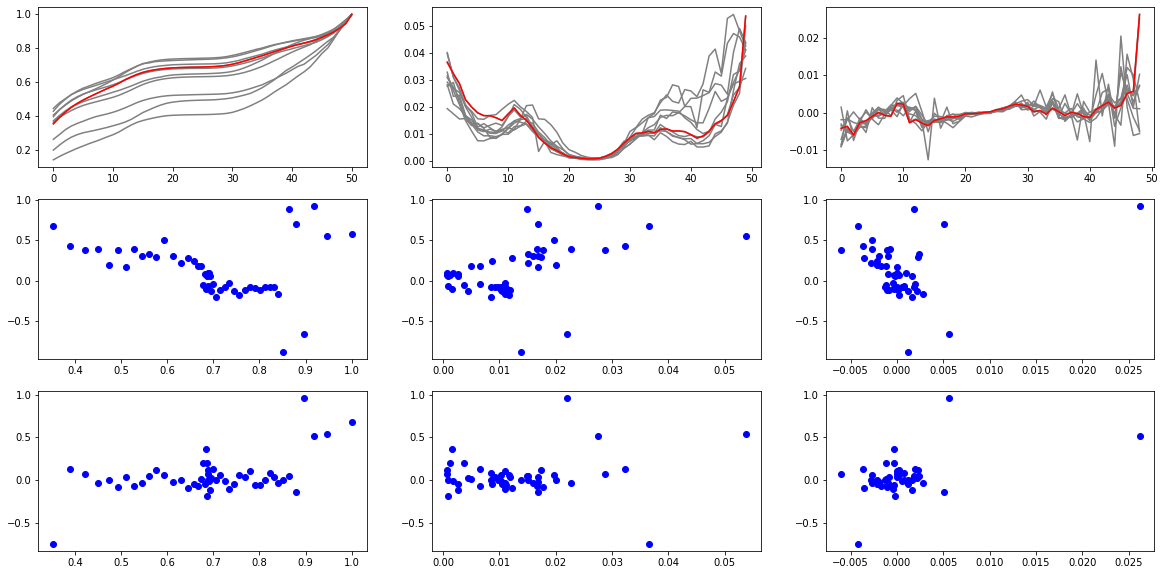

In [22]:
localData = NorthDataSet[NorthDataSet["Geo_Location"]=="USA: New York"]

fig,axs = plt.subplots(3,3,figsize=(20,10))

for st in StateData:
    
    axs[0,0].plot(st,color="gray")
    axs[0,1].plot(np.diff(st,n=1),color="gray")
    axs[0,2].plot(np.diff(st,n=2),color="gray")

axs[0,0].plot(StateData[5],color="red")
axs[0,1].plot(np.diff(StateData[5],n=1),color="red")
axs[0,2].plot(np.diff(StateData[5],n=2),color="red")

axs[1,0].plot(StateData[5],np.array(localData.groupby("week")["latentA"].mean()),'bo')
axs[1,1].plot(np.diff(StateData[5],n=1),np.array(localData.groupby("week")["latentA"].mean())[0:-1],'bo')
axs[1,2].plot(np.diff(StateData[5],n=2),np.array(localData.groupby("week")["latentA"].mean())[0:-2],'bo')

axs[2,0].plot(StateData[5],np.array(localData.groupby("week")["latentB"].mean()),'bo')
axs[2,1].plot(np.diff(StateData[5],n=1),np.array(localData.groupby("week")["latentB"].mean())[0:-1],'bo')
axs[2,2].plot(np.diff(StateData[5],n=2),np.array(localData.groupby("week")["latentB"].mean())[0:-2],'bo')

## Massachusetts

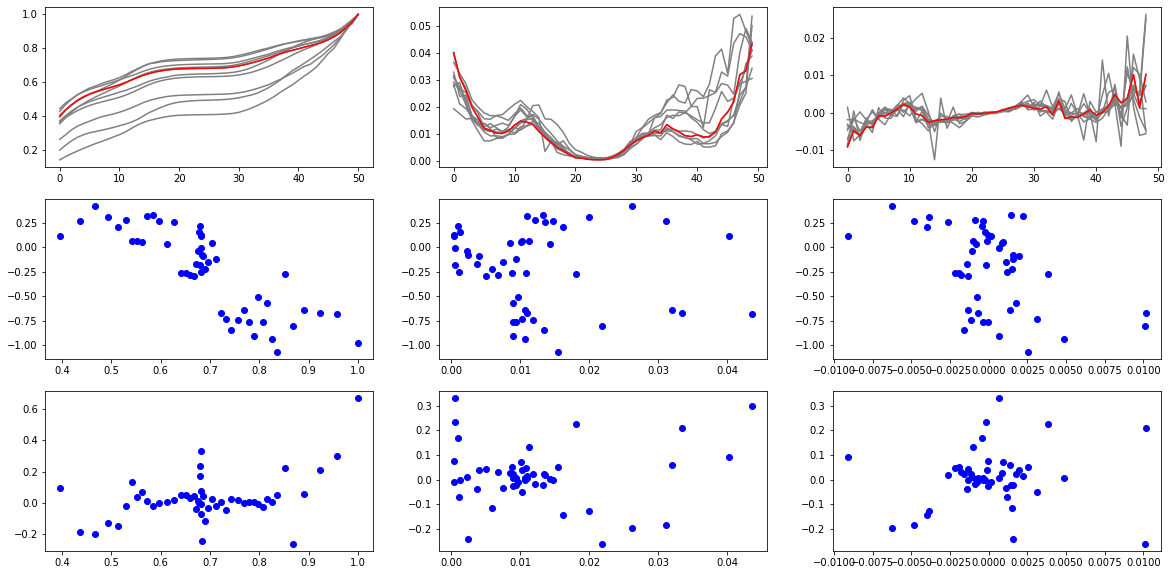

In [23]:
localData = NorthDataSet[NorthDataSet["Geo_Location"]=="USA: Massachusetts"]

fig,axs = plt.subplots(3,3,figsize=(20,10))

for st in StateData:
    
    axs[0,0].plot(st,color="gray")
    axs[0,1].plot(np.diff(st,n=1),color="gray")
    axs[0,2].plot(np.diff(st,n=2),color="gray")

axs[0,0].plot(StateData[3],color="red")
axs[0,1].plot(np.diff(StateData[3],n=1),color="red")
axs[0,2].plot(np.diff(StateData[3],n=2),color="red")

axs[1,0].plot(StateData[3],np.array(localData.groupby("week")["latentA"].mean())[0:-2],'bo')
axs[1,1].plot(np.diff(StateData[3],n=1),np.array(localData.groupby("week")["latentA"].mean())[0:-3],'bo')
axs[1,2].plot(np.diff(StateData[3],n=2),np.array(localData.groupby("week")["latentA"].mean())[0:-4],'bo')

axs[2,0].plot(StateData[3],np.array(localData.groupby("week")["latentB"].mean())[0:-2],'bo')
axs[2,1].plot(np.diff(StateData[3],n=1),np.array(localData.groupby("week")["latentB"].mean())[0:-3],'bo')
axs[2,2].plot(np.diff(StateData[3],n=2),np.array(localData.groupby("week")["latentB"].mean())[0:-4],'bo')

## Pennsylvania

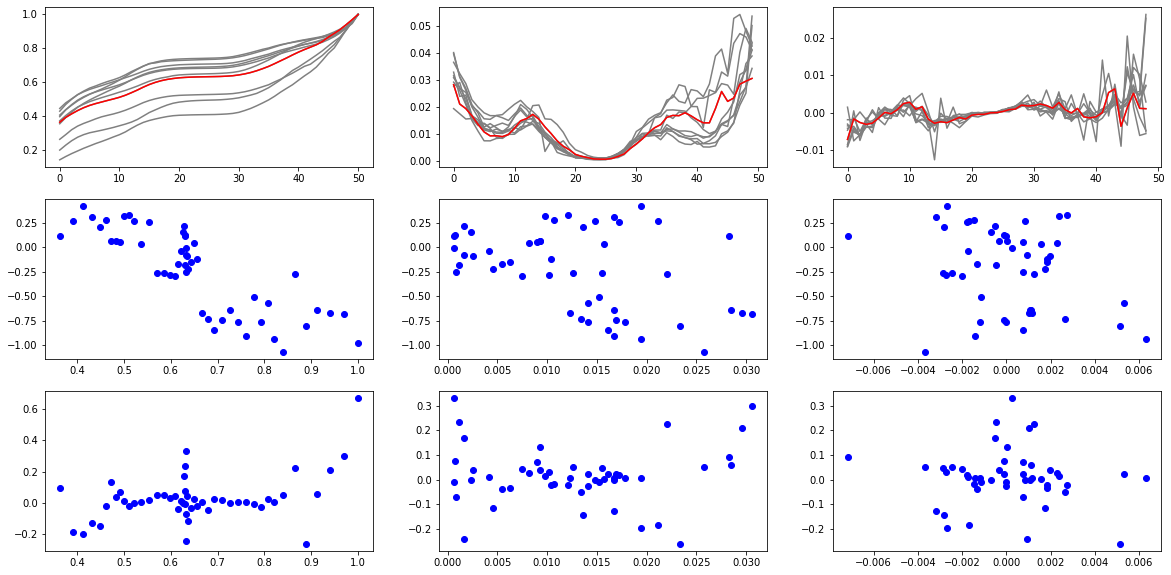

In [24]:
VMData = NorthDataSet[NorthDataSet["Geo_Location"]=="USA: Pennsylvania"]

fig,axs = plt.subplots(3,3,figsize=(20,10))

for st in StateData:
    
    axs[0,0].plot(st,color="gray")
    axs[0,1].plot(np.diff(st,n=1),color="gray")
    axs[0,2].plot(np.diff(st,n=2),color="gray")

axs[0,0].plot(StateData[8],color="red")
axs[0,1].plot(np.diff(StateData[8],n=1),color="red")
axs[0,2].plot(np.diff(StateData[8],n=2),color="red")

axs[1,0].plot(StateData[8],np.array(localData.groupby("week")["latentA"].mean())[0:-2],'bo')
axs[1,1].plot(np.diff(StateData[8],n=1),np.array(localData.groupby("week")["latentA"].mean())[0:-3],'bo')
axs[1,2].plot(np.diff(StateData[8],n=2),np.array(localData.groupby("week")["latentA"].mean())[0:-4],'bo')

axs[2,0].plot(StateData[8],np.array(localData.groupby("week")["latentB"].mean())[0:-2],'bo')
axs[2,1].plot(np.diff(StateData[8],n=1),np.array(localData.groupby("week")["latentB"].mean())[0:-3],'bo')
axs[2,2].plot(np.diff(StateData[8],n=2),np.array(localData.groupby("week")["latentB"].mean())[0:-4],'bo')

From the selected examples looks like there is a particular correlation between either cases rate or acceleration of the cases and the learned representation. However, this correlation is perhaps hindered by the noise in the acceleration approximation. 

Although the cross-validation is not optimal and the data set presents geographical and temporal imbalances. The ability to find temporal patterns suggest the existence of such patterns but not the ability to generalize at least with the current configuration. 

However, is worth mentioning that relational encoding offers a viable solution to encode large sequences and find meaningful patterns using convolutional neural networks. The computer vision approach may favor representations where the sequences share some common global similarity and specific patterns in the sequence might be lost. However relational encoding can also be used for Graph neural networks to identify important node clusters that could lead to specific genomic regions. The continuous development of these models could lead to a better understanding of the Covid-19 pandemic and the introduction of new preventive measures. 

Further details at https://tavoglc.medium.com/sars-cov-2-classification-with-variational-autoencoders-4842696a43c